In [ ]:
 #GW_audiotest_CE: This project focuses on data from Cosmic explorer setting max distance and number of signals proportional to the studies from cosmic explorer.

In [ ]:
#import packages

#import pycbc Ligo package
import sys 
!{sys.executable} -m pip install pycbc lalsuite ligo-common --no-cache-dir 
from pycbc.waveform import get_td_waveform 
from pycbc.waveform import td_approximants 
from pycbc.types import TimeSeries 
from pycbc import waveform 
from astropy.cosmology import WMAP9 as cosmo

import numpy as np # i am a comment
import scipy 
import pylab 
import pylab as plt 


from IPython.display import Audio
from scipy.io import wavfile

#Phil Landry package
! git clone https://github.com/landryp/sodapop.git 
sys.path.insert(0,'/content/sodapop')
import sodapop.populations as pop

     |████████████████████████████████| 6.7 MB 3.2 MB/s 
     |████████████████████████████████| 27.6 MB 1.5 MB/s 
     |████████████████████████████████| 1.0 MB 53.3 MB/s 
     |████████████████████████████████| 1.6 MB 65.8 MB/s 
     |████████████████████████████████| 51 kB 58.4 MB/s 
     |████████████████████████████████| 75 kB 62.4 MB/s 
     |████████████████████████████████| 55 kB 38.4 MB/s 
     |████████████████████████████████| 3.5 MB 71.8 MB/s 
  Created wheel for lscsoft-glue: filename=lscsoft_glue-2.0.0-cp37-cp37m-linux_x86_64.whl size=416838 sha256=b6cfe31a65957f5598cc1fc08578b1f06f53014a5aed2c8d8124d076f9496530
  Stored in directory: /tmp/pip-ephem-wheel-cache-dhp_40z5/wheels/9d/ed/9e/1f9cad5e15359dc17954b893dd486760b5cb1ffd97a8405d1e
  Created wheel for mpld3: filename=mpld3-0.5.5-py3-none-any.whl size=200907 sha256=c7bd7b066e1bc699e1d8be27b11377274a99f6ce3c2837d87566685114415586
  Stored in directory: /tmp/pip-ephem-wheel-cache-dhp_40z5/wheels/3b/f3/08/a11447ac4ea31d76

In [ ]:
#User input

#soundfile settings
SOUNDLENGTH=60. #length of soundfile in seconds
COMPRESSIONRATE=60. #factor to mutlilple rate by to speed up time
DELTA_T= 1.0/4096 #sampling rate 
FLOW= 15.0 #low frequency cut off for waveforms
OUTFILENAME='ce_soundscape.wav'#soundfile name

#bbh settings
BBHPOP= 'o3a_powerpeak_m1m2_qpair' #choice of bbh mass distribution
BBH_RATE=100000*COMPRESSIONRATE/(365*24*60*60) #bbh rate per sec [from cehs box 7.3]
NUMBBH=int(SOUNDLENGTH*BBH_RATE) #number bbh to include
MINBBH=1. #minimum bbh mass
MAXBBH=100. #maximum bbh mass
MAXZ=10. #maximum distance for bbh mass [z=10]

#bns settings
BNSPOP='bimodcut_m1m2'
BNS_RATE=300000*COMPRESSIONRATE/(365*24*60*60) #[from cehs box 7.3]
NUMBNS=int(SOUNDLENGTH*BNS_RATE)
MINBNS=1.
MAXBNS=3.
MAXZBNS=44479. #maximum distance for bns mass [z=10]

In [ ]:
#Define waveform function
def generate_3g_waveform(m1,m2,distance, time): 
    hp, hc = get_td_waveform(approximant='TaylorT4', 
                                 mass1=m1, 
                                 mass2=m2, 
                                 distance = distance, 
                                 delta_t=DELTA_T, 
                                 f_lower=FLOW) 
    hp._epoch = hp._epoch + np.around(time,1) # take whatever start time is generated and shift it by the amount of time we want 
    #NOTE: time must be rounded to one decimal place otherwise epoch adding fails 
    return hp

In [ ]:
#Make bbh Distribution and sample from it

#build grid m1 & m2
bhmassgrid=np.linspace(MINBBH,MAXBBH,1000)
mass1sgrid, mass2sgrid = np.meshgrid(bhmassgrid, bhmassgrid, sparse=False)
bbhmassgrid = np.vstack([mass1sgrid.ravel(), mass2sgrid.ravel()]).T

#calculate probability at each grid point according to mass distribution
bbhmass_distrib = pop.get_pop_prior(BBHPOP)
bbhprobs =[bbhmass_distrib(m1,m2) for m1,m2 in bbhmassgrid]

#Draw bbh masses accord to those probabilities 
indexes=np.random.choice(range(len(bbhmassgrid)),size=NUMBBH,p=bbhprobs/np.sum(bbhprobs))
m1listbbh = []
m2listbbh = []

for index in indexes:
  binary = bbhmassgrid[index]
  m1listbbh.append(max(binary))
  m2listbbh.append(min(binary))

#Build grid distances and merger time

timegridbbh=np.linspace(5.,SOUNDLENGTH,1000)

redshiftgridbbh = np.linspace(0,MAXZ,100000)

diffVcgrid = 4.0 * np.pi * cosmo.differential_comoving_volume(redshiftgridbbh).value
ndotgrid = 1.0 # constant merger rate to start
scalefactorgrid = cosmo.scale_factor(redshiftgridbbh) 

#Create distribution of distance bbh
redshift_distrib = diffVcgrid *ndotgrid *scalefactorgrid # Number of sources at distance R is proportional to a shell of area R^2 at each R
redshift_distrib = redshift_distrib/np.sum(redshift_distrib) #Normalize the distribution


#Draw random time distance bbh
bbht=np.random.choice(timegridbbh,size=NUMBBH)
bbhz=np.random.choice(a=redshiftgridbbh,size=NUMBBH,p=redshift_distrib)


In [ ]:
#Make bns Distribution and sample from it

#build grid m1 & m2
nsmassgrid=np.linspace(MINBNS,MAXBNS,1000)
mass1sgrid, mass2sgrid = np.meshgrid(nsmassgrid, nsmassgrid, sparse=False)
bnsmassgrid = np.vstack([mass1sgrid.ravel(), mass2sgrid.ravel()]).T

#calculate probability at each grid point according to mass distribution
bnsmass_distrib = pop.get_pop_prior(BNSPOP)
bnsprobs =[bnsmass_distrib(m1,m2) for m1,m2 in bnsmassgrid]

#Draw bns masses accord to those probabilities 
indexes=np.random.choice(range(len(bnsmassgrid)),size=NUMBNS,p=bnsprobs/np.sum(bnsprobs))
m1listbns = []
m2listbns = []

for index in indexes:
  binary = bnsmassgrid[index]
  m1listbns.append(max(binary))
  m2listbns.append(min(binary))

#Build grid distances and merger time

timegridbns=np.linspace(5.,SOUNDLENGTH,1000)

redshiftgridbns = np.linspace(0,MAXZBNS,100000)

diffVcgrid = 4.0 * np.pi * cosmo.differential_comoving_volume(redshiftgridbns).value
ndotgrid = 1.0 # constant merger rate to start
scalefactorgrid = cosmo.scale_factor(redshiftgridbns) 

#Create distribution of distance bns
redshift_distribbns = diffVcgrid *ndotgrid *scalefactorgrid # Number of sources at distance R is proportional to a shell of area R^2 at each R
redshift_distribbns = redshift_distribbns/np.sum(redshift_distribbns) #Normalize the distribution 

#Draw random time distance bns
bnst=np.random.choice(timegridbns,size=NUMBNS)
bnsz=np.random.choice(a=redshiftgridbns,size=NUMBNS,p=redshift_distribbns)

In [ ]:
#Generate bbh waveforms and put them in a timeseries
numtimes=int(SOUNDLENGTH/DELTA_T)
wavebasebbh = TimeSeries( np.zeros(numtimes) ,delta_t=DELTA_T)


for i in range(NUMBBH):
   m1=m1listbbh[i]
   m2=m2listbbh[i]
   distance=bbhz[i]
   time=bbht[i]
   wave1 = generate_3g_waveform(m1,m2,distance,time) 

   wavebasebbh = wavebasebbh.add_into(wave1) # add wave1


In [ ]:
#Generate bns waveforms and put them in a timeseries
numtimes=int(SOUNDLENGTH/DELTA_T)
wavebasebns = TimeSeries( np.zeros(numtimes) ,delta_t=DELTA_T)


for i in range(NUMBNS):
   m1=m1listbns[i]
   m2=m2listbns[i]
   distance=bnsz[i]
   time=bnst[i]
   wave1 = generate_3g_waveform(m1,m2,distance,time) 

   wavebasebns = wavebasebns.add_into(wave1) # add wave1

In [ ]:
#Make wavefile
wavebase = TimeSeries( np.zeros(numtimes) ,delta_t=DELTA_T)
wavebase = wavebase.add_into(wavebasebbh) # add wave1
wavebase = wavebase.add_into(wavebasebns) # add wave2
wavearray = np.array(wavebase)/np.max(np.array(wavebase))
scipy.io.wavfile.write(OUTFILENAME,int(1/DELTA_T),wavearray)

#Soundfile Player
data = wavfile.read('ce_soundscape.wav')
framerate = 4096
sounddata = data[1]

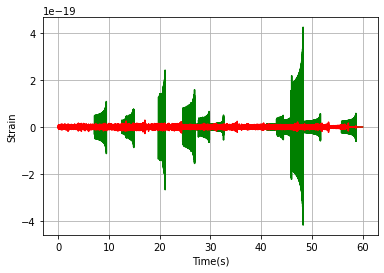

In [ ]:
#Plot bbh & bns waveform
plt.plot(wavebasebbh.sample_times, wavebasebbh, label = "m1 = {0}, m2 = {1}".format(m1,m2),color='g')
plt.plot(wavebasebns.sample_times, wavebasebns, label = "m1 = {0}, m2 = {1}".format(m1,m2),color='r')

plt.grid()
plt.xlabel('Time(s)')
plt.ylabel('Strain')

#Audio Player
Audio(sounddata,rate=framerate)